In [1]:
%load_ext autoreload

In [2]:
%run ./common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/figures


In [3]:
%autoreload 2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import HashingEncoder, OneHotEncoder, OrdinalEncoder

# Load custom code
import kdd98.data_handler as dh
import kdd98.utils_transformer as ut
from kdd98.transformers import *
from kdd98.config import Config

Using TensorFlow backend.


In [4]:
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'preprocessing')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = pathlib.Path(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
data_provider = dh.KDD98DataProvider("cup98LRN.txt")

# Imputation

A high-level look at missing data: White represents missing values. To the right, we can see the exampple with the least and most non-NA values.

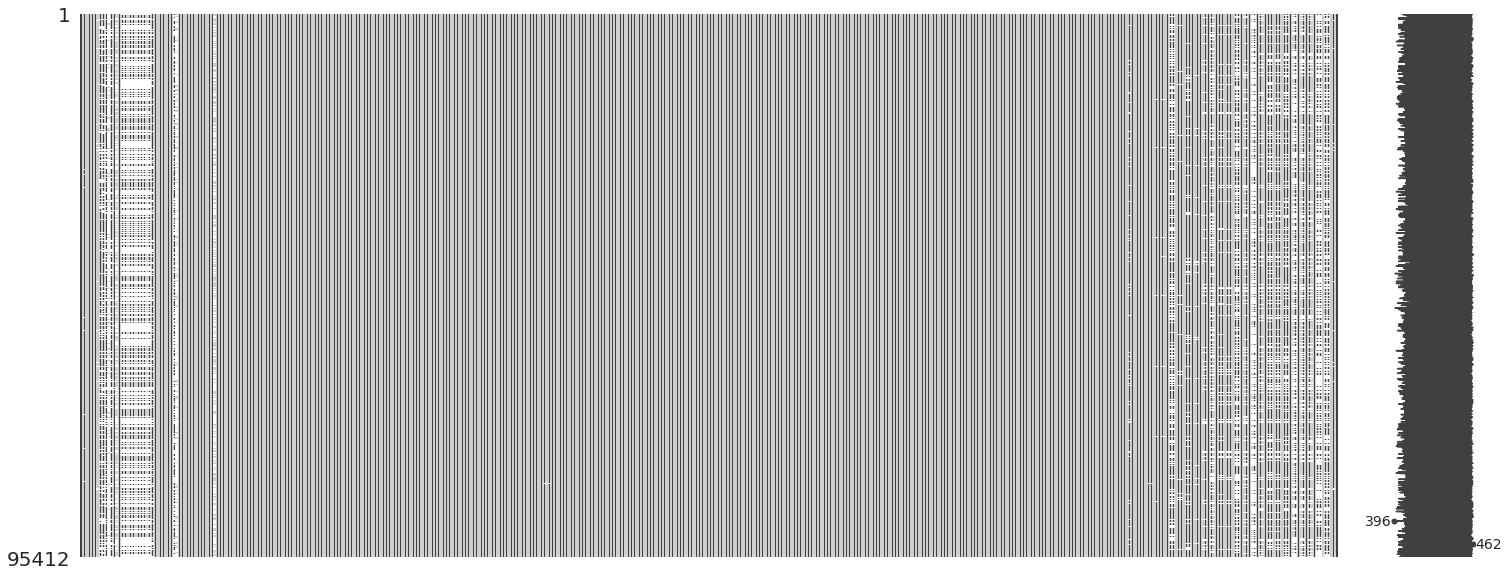

In [7]:
import missingno as msno
msno.matrix(learning_preprocessed)
save_fig("missing_matrix", tight_layout=False)

## Categoricals

Nominal features cannot be imputed by sophisticated imputation methods. The nominal features are therefore first imputed using the mode of each feature.

In [ ]:
categoricals = learning_preprocessed.select_dtypes(include="category")
categorical_features = categoricals.columns.values.tolist()

In [ ]:
imputed_categoricals = categoricals.fillna(categoricals.mode().iloc[0])

In [ ]:
for c in imputed_categoricals[[c for c in imputed_categoricals.columns if imputed_categoricals[c].cat.categories.dtype == 'object']]:
    print("{} has {} levels:\n{}".format(c,len(categoricals[c].cat.categories),categoricals[c].cat.categories))
    print("Number of missing values left: {}".format(imputed_categoricals[c].isna().sum()))

In [ ]:
learning_preprocessed[imputed_categoricals.columns] = imputed_categoricals

In [4]:
learning_numeric = data_provider.numeric_data

NameError: name 'data_provider' is not defined

## missingpy
https://github.com/epsilon-machine/missingpy

Olga Troyanskaya, Michael Cantor, Gavin Sherlock, Pat Brown, Trevor Hastie, Robert Tibshirani, David Botstein and Russ B. Altman, Missing value estimation methods for DNA microarrays, BIOINFORMATICS Vol. 17 no. 6, 2001 Pages 520-525

This step requires that we first drop features with more than 80% missing values for the KNNImputer to work.

Best results with k=3: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4959387/

In [ ]:
from missingpy import KNNImputer
imputer = KNNImputer(n_neighbors=3, weights="distance",)

In [ ]:
learning_numerical = learning_preprocessed.loc[:,learning_preprocessed.select_dtypes("number").columns.values.tolist()]
sparse_features = [c for c in learning_numerical.columns if learning_numerical[c].count() / len(learning_numerical.index) <= 0.2]
print(sparse_features)

In [ ]:
learning_numerical.drop(sparse_features, axis=1,inplace=True)

In [ ]:
imputed = imputer.fit_transform(learning_numerical.values)

## fancyimpute

In [ ]:
from fancyimpute import IterativeImputer

In [ ]:
learning_numerical.info()

In [ ]:
imputed = IterativeImputer(n_iter=5,initial_strategy="median", random_state=Config.get("random_seed"),verbose=1).fit_transform(learning_numerical)

In [ ]:
imputed = pd.DataFrame(data=imputed, columns = learning_numerical.columns, index=learning_numerical.index)

In [ ]:
imputed.isna().sum().sum()